#genetic variations associated with vitamin utilization

In [4]:
!pip install biopython

Genetic Variations Associated with Vitamin Utilization (BioPython Version)

Generating simulated genotype and phenotype data...


<ipython-input-5-c0c3066230fe>:176: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)



Summary statistics for vitamin levels in the sample:
       vitamin_d_level  vitamin_b12_level  folate_level
count       200.000000         200.000000    200.000000
mean         24.081739         364.171172     11.516349
std           6.388929         130.411719      3.661838
min           5.000000         100.000000      3.000000
25%          19.626112         279.264584      9.216295
50%          23.806195         371.325858     11.468626
75%          28.777896         448.836199     13.717903
max          41.610624         736.055592     21.463449

Analyzing genetic variants associated with vitamin D metabolism:

Effect of rs2282679 (GC gene) on vitamin D levels:
                mean       std  count
rs2282679                            
0          26.175021  6.186509     74
1          25.516593  5.174445     45
2          21.372217  6.264269     81
ANOVA results: F=14.01, p=0.0000

Analyzing genetic variants associated with vitamin B12 metabolism:

Effect of rs602662 (FUT2 gene) o

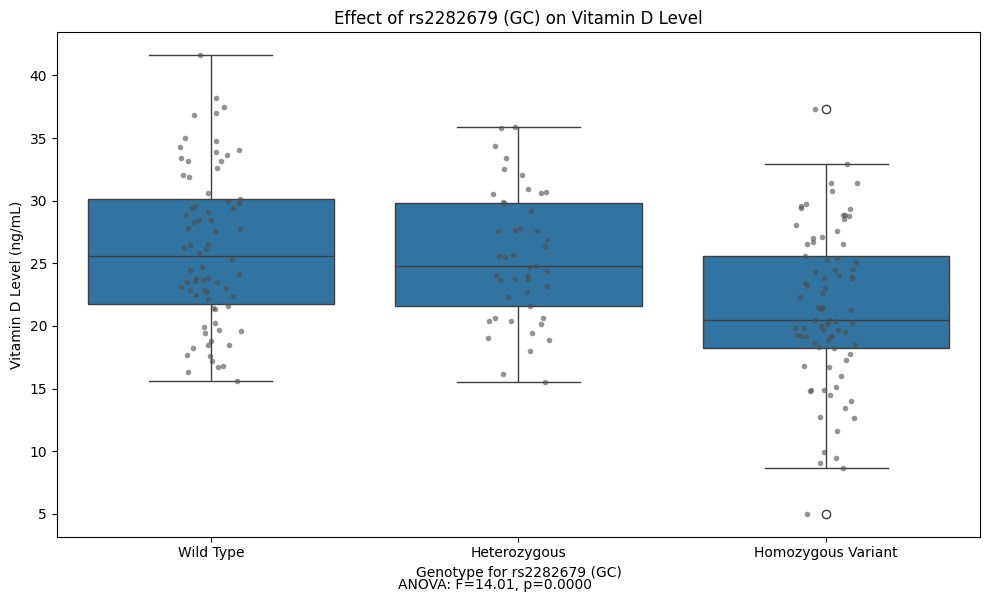

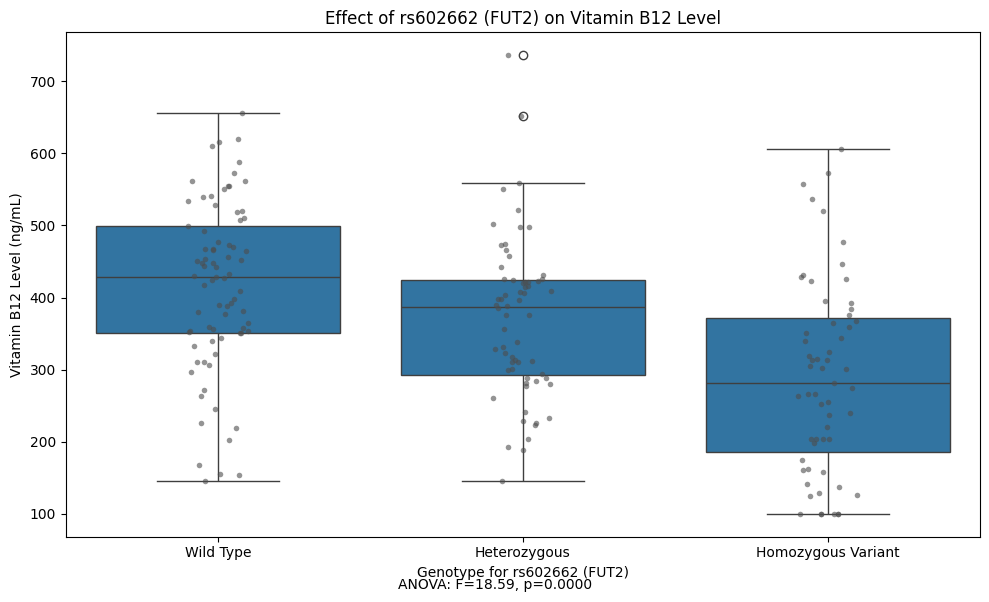

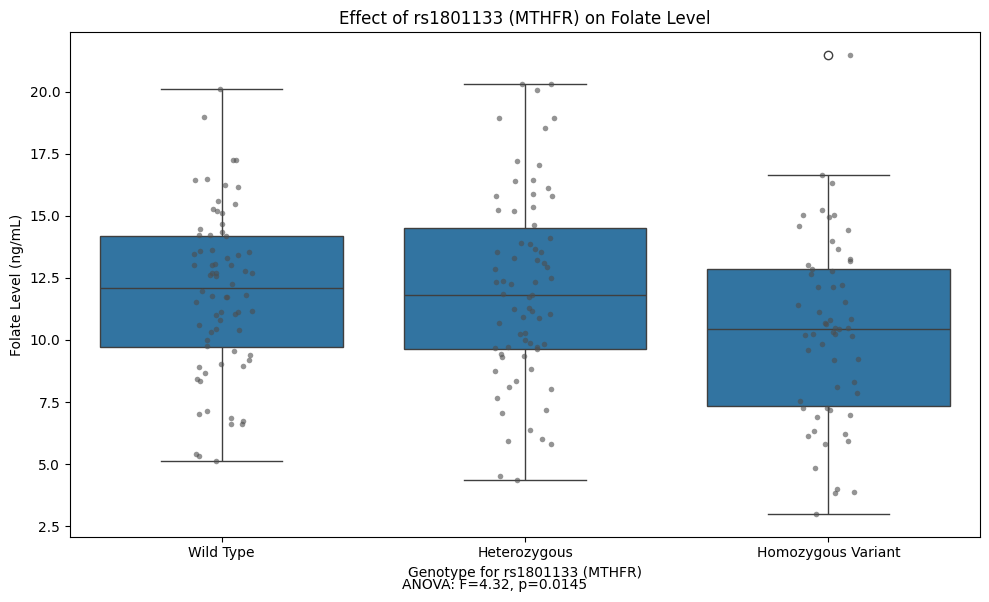


Analysis complete.

Note: For demonstration purposes, this script uses simulated data.
In a real application, you would use actual genetic data from sequencing
or genotyping arrays, and query live databases for the most current information.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from Bio import SeqIO, Entrez
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast import NCBIWWW
import io
import re
import time

# Set your email for Entrez services
Entrez.email = "your_email@example.com"  # Replace with your email

# Define some common genetic variants associated with vitamin metabolism
vitamin_snps = {
    'Vitamin D': [
        {'SNP': 'rs2282679', 'Gene': 'GC', 'Effect': 'Affects vitamin D binding protein', 'RefSeq': 'NC_000004.12'},
        {'SNP': 'rs10741657', 'Gene': 'CYP2R1', 'Effect': 'Affects vitamin D 25-hydroxylase', 'RefSeq': 'NC_000011.10'},
        {'SNP': 'rs7041', 'Gene': 'GC', 'Effect': 'Affects vitamin D binding protein structure', 'RefSeq': 'NC_000004.12'}
    ],
    'Vitamin B12': [
        {'SNP': 'rs602662', 'Gene': 'FUT2', 'Effect': 'Affects B12 absorption', 'RefSeq': 'NC_000019.10'},
        {'SNP': 'rs1801198', 'Gene': 'TCN2', 'Effect': 'Affects B12 transport protein', 'RefSeq': 'NC_000022.11'},
        {'SNP': 'rs3760775', 'Gene': 'CUBN', 'Effect': 'Affects intestinal B12 receptor', 'RefSeq': 'NC_000010.11'}
    ],
    'Folate': [
        {'SNP': 'rs1801133', 'Gene': 'MTHFR', 'Effect': 'Reduces enzyme activity by 30-70%', 'RefSeq': 'NC_000001.11'},
        {'SNP': 'rs1801131', 'Gene': 'MTHFR', 'Effect': 'Reduces enzyme activity by 30-40%', 'RefSeq': 'NC_000001.11'},
        {'SNP': 'rs1805087', 'Gene': 'MTR', 'Effect': 'Affects methionine synthase function', 'RefSeq': 'NC_000001.11'}
    ]
}

# Function to fetch SNP information from NCBI
def fetch_snp_info(rs_id):
    """Fetch SNP information from NCBI dbSNP database"""
    try:
        # Search for the SNP in dbSNP
        handle = Entrez.esearch(db="snp", term=rs_id)
        record = Entrez.read(handle)
        handle.close()

        if not record["IdList"]:
            print(f"No information found for {rs_id}")
            return None

        # Get detailed information
        snp_id = record["IdList"][0]
        handle = Entrez.efetch(db="snp", id=snp_id, retmode="xml")
        snp_record = Entrez.read(handle)
        handle.close()

        return snp_record
    except Exception as e:
        print(f"Error fetching SNP info for {rs_id}: {e}")
        return None

# Function to generate simple DNA sequence for simulation
def generate_dna_sequence(length=1000):
    """Generate a random DNA sequence"""
    bases = ['A', 'T', 'G', 'C']
    sequence = ''.join([np.random.choice(bases) for _ in range(length)])
    return Seq(sequence)

# Function to introduce SNPs into a sequence
def introduce_snp_in_sequence(sequence, position, reference, alternate):
    """Introduce a SNP into a DNA sequence"""
    seq_str = str(sequence)
    if position < len(seq_str) and seq_str[position] == reference:
        modified_seq = seq_str[:position] + alternate + seq_str[position+1:]
        return Seq(modified_seq)
    else:
        # If the position is invalid or the reference base doesn't match, return the original sequence
        return sequence

# Function to simulate sample genotypes and vitamin levels
def generate_genotype_data(n_samples=100):
    """Generate simulated genotype and vitamin level data with BioPython elements"""
    np.random.seed(42)  # For reproducibility

    # Create empty dataframe
    columns = ['sample_id', 'vitamin_d_level', 'vitamin_b12_level', 'folate_level']

    # Add SNPs to columns
    for vitamin, snps in vitamin_snps.items():
        for snp in snps:
            columns.append(snp['SNP'])

    df = pd.DataFrame(columns=columns)

    # Generate a reference genome (simplified for simulation)
    ref_sequences = {}
    for vitamin, snps in vitamin_snps.items():
        for snp in snps:
            gene = snp['Gene']
            if gene not in ref_sequences:
                # Generate a random sequence for this gene
                ref_sequences[gene] = generate_dna_sequence(1000)

    # Create sample records
    sample_records = []

    # Fill with simulated data
    for i in range(n_samples):
        row = {'sample_id': f'SAMPLE_{i+1}'}

        # Generate random genotypes (0=homozygous reference, 1=heterozygous, 2=homozygous alternate)
        for vitamin, snps in vitamin_snps.items():
            for snp in snps:
                genotype = np.random.choice([0, 1, 2])
                row[snp['SNP']] = genotype

                # Create modified sequences for this sample based on genotype
                gene = snp['Gene']
                ref_seq = ref_sequences[gene]

                # Simulate SNP position and alleles (in a real scenario these would be fetched from dbSNP)
                snp_position = np.random.randint(10, len(ref_seq) - 10)
                ref_base = str(ref_seq[snp_position])
                alt_base = np.random.choice([b for b in ['A', 'T', 'G', 'C'] if b != ref_base])

                # Create sample sequence with SNP
                if genotype == 0:  # Homozygous reference
                    sample_seq = ref_seq
                elif genotype == 1:  # Heterozygous
                    sample_seq = introduce_snp_in_sequence(ref_seq, snp_position, ref_base, alt_base)
                else:  # Homozygous alternate
                    sample_seq = introduce_snp_in_sequence(ref_seq, snp_position, ref_base, alt_base)

                # Create a SeqRecord for this sample's gene
                record = SeqRecord(
                    sample_seq,
                    id=f"{row['sample_id']}_{gene}",
                    name=f"{gene} variant",
                    description=f"Sample {row['sample_id']} {gene} gene with {snp['SNP']} genotype {genotype}"
                )
                sample_records.append(record)

        # Base vitamin levels - random values in typical ranges
        base_vit_d = np.random.normal(30, 5)  # ng/mL
        base_vit_b12 = np.random.normal(500, 100)  # pg/mL
        base_folate = np.random.normal(15, 3)  # ng/mL

        # Modify vitamin levels based on genotypes
        # Vitamin D modifiers
        vit_d_effect = 0
        for snp in vitamin_snps['Vitamin D']:
            if row[snp['SNP']] == 1:  # heterozygous
                vit_d_effect -= 2
            elif row[snp['SNP']] == 2:  # homozygous alternate
                vit_d_effect -= 4

        # Vitamin B12 modifiers
        vit_b12_effect = 0
        for snp in vitamin_snps['Vitamin B12']:
            if row[snp['SNP']] == 1:  # heterozygous
                vit_b12_effect -= 50
            elif row[snp['SNP']] == 2:  # homozygous alternate
                vit_b12_effect -= 100

        # Folate modifiers
        folate_effect = 0
        for snp in vitamin_snps['Folate']:
            if row[snp['SNP']] == 1:  # heterozygous
                folate_effect -= 1
            elif row[snp['SNP']] == 2:  # homozygous alternate
                folate_effect -= 2

        # Apply effects with some randomness
        row['vitamin_d_level'] = max(5, base_vit_d + vit_d_effect + np.random.normal(0, 2))
        row['vitamin_b12_level'] = max(100, base_vit_b12 + vit_b12_effect + np.random.normal(0, 30))
        row['folate_level'] = max(3, base_folate + folate_effect + np.random.normal(0, 1))

        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    # Save the sample sequence records to a FASTA file (optional)
    if sample_records:
        with open("sample_gene_sequences.fasta", "w") as output_handle:
            SeqIO.write(sample_records[:10], output_handle, "fasta")  # Save just first 10 for demo

    return df, sample_records

# Function to analyze the effect of a specific SNP on vitamin levels
def analyze_snp_effect(df, snp_id, vitamin_level):
    """Analyze the effect of a specific SNP on vitamin levels"""
    # Group by genotype
    groups = df.groupby(snp_id)[vitamin_level].agg(['mean', 'std', 'count'])

    # Perform ANOVA to test for significant differences
    genotype_groups = []
    for genotype in sorted(df[snp_id].unique()):
        genotype_groups.append(df[df[snp_id] == genotype][vitamin_level])

    f_stat, p_value = stats.f_oneway(*genotype_groups)

    return groups, f_stat, p_value

# Function to visualize the effect of a SNP on vitamin levels
def plot_snp_effect(df, snp_id, vitamin_level, gene_name):
    """Create a boxplot showing the effect of a SNP on vitamin levels"""
    plt.figure(figsize=(10, 6))

    # Create a boxplot
    sns.boxplot(x=snp_id, y=vitamin_level, data=df)

    # Add individual data points
    sns.stripplot(x=snp_id, y=vitamin_level, data=df, size=4, color=".3", alpha=0.6)

    # Add labels and title
    plt.xlabel(f'Genotype for {snp_id} ({gene_name})')
    plt.ylabel(f'{vitamin_level.replace("_", " ").title()} (ng/mL)')
    plt.title(f'Effect of {snp_id} ({gene_name}) on {vitamin_level.replace("_", " ").title()}')

    # Add genotype labels
    genotype_labels = {0: 'Wild Type', 1: 'Heterozygous', 2: 'Homozygous Variant'}
    plt.xticks([0, 1, 2], [genotype_labels[0], genotype_labels[1], genotype_labels[2]])

    # Add stats
    groups, f_stat, p_value = analyze_snp_effect(df, snp_id, vitamin_level)
    plt.figtext(0.5, 0.01, f'ANOVA: F={f_stat:.2f}, p={p_value:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

# Function to compute consensus sequence using BioPython
def compute_consensus_sequence(sequence_records, gene_name):
    """Compute a consensus sequence from a list of sequence records"""
    if not sequence_records:
        return None

    # Filter records for the specific gene
    gene_records = [rec for rec in sequence_records if gene_name in rec.id]

    if not gene_records:
        return None

    # Simple consensus approach (for demonstration - BioPython has more complex methods)
    # Get the length of the first sequence
    seq_length = len(gene_records[0].seq)

    # Count nucleotides at each position
    consensus = ""
    for i in range(seq_length):
        nucleotides = [str(rec.seq[i]) for rec in gene_records]
        counts = {'A': 0, 'T': 0, 'G': 0, 'C': 0}
        for n in nucleotides:
            if n in counts:
                counts[n] += 1

        # Find the most common nucleotide
        consensus += max(counts, key=counts.get)

    return Seq(consensus)

# Function to search for potential vitamin-related genes
def search_vitamin_genes(vitamin_type):
    """Search for genes related to a specific vitamin using NCBI Entrez"""
    try:
        # Search for genes related to the vitamin
        search_term = f"{vitamin_type}[Title] AND metabolism[Title] AND human[Organism]"
        handle = Entrez.esearch(db="gene", term=search_term, retmax=5)
        record = Entrez.read(handle)
        handle.close()

        if not record["IdList"]:
            print(f"No genes found for {vitamin_type}")
            return []

        # Get details for each gene
        genes = []
        for gene_id in record["IdList"]:
            handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
            gene_records = Entrez.read(handle)
            handle.close()

            if gene_records:
                gene_info = gene_records[0]
                gene_name = gene_info.get("Entrezgene_gene", {}).get("Gene-ref", {}).get("Gene-ref_locus", "Unknown")
                gene_desc = gene_info.get("Entrezgene_gene", {}).get("Gene-ref", {}).get("Gene-ref_desc", "No description")

                genes.append({
                    "gene_id": gene_id,
                    "name": gene_name,
                    "description": gene_desc
                })

        return genes
    except Exception as e:
        print(f"Error searching for vitamin genes: {e}")
        return []

# Main analysis
def main():
    print("Genetic Variations Associated with Vitamin Utilization (BioPython Version)")
    print("="*70)

    # Generate sample data with BioPython elements
    print("\nGenerating simulated genotype and phenotype data...")
    df, sample_records = generate_genotype_data(200)

    # Summary statistics
    print("\nSummary statistics for vitamin levels in the sample:")
    vitamin_stats = df[['vitamin_d_level', 'vitamin_b12_level', 'folate_level']].describe()
    print(vitamin_stats)

    # Analyze key SNPs for each vitamin
    print("\nAnalyzing genetic variants associated with vitamin D metabolism:")
    vit_d_key_snp = 'rs2282679'  # GC gene
    groups_d, f_stat_d, p_value_d = analyze_snp_effect(df, vit_d_key_snp, 'vitamin_d_level')
    print(f"\nEffect of {vit_d_key_snp} (GC gene) on vitamin D levels:")
    print(groups_d)
    print(f"ANOVA results: F={f_stat_d:.2f}, p={p_value_d:.4f}")

    print("\nAnalyzing genetic variants associated with vitamin B12 metabolism:")
    vit_b12_key_snp = 'rs602662'  # FUT2 gene
    groups_b12, f_stat_b12, p_value_b12 = analyze_snp_effect(df, vit_b12_key_snp, 'vitamin_b12_level')
    print(f"\nEffect of {vit_b12_key_snp} (FUT2 gene) on vitamin B12 levels:")
    print(groups_b12)
    print(f"ANOVA results: F={f_stat_b12:.2f}, p={p_value_b12:.4f}")

    print("\nAnalyzing genetic variants associated with folate metabolism:")
    folate_key_snp = 'rs1801133'  # MTHFR gene
    groups_folate, f_stat_folate, p_value_folate = analyze_snp_effect(df, folate_key_snp, 'folate_level')
    print(f"\nEffect of {folate_key_snp} (MTHFR gene) on folate levels:")
    print(groups_folate)
    print(f"ANOVA results: F={f_stat_folate:.2f}, p={p_value_folate:.4f}")

    # Compute consensus sequences for each gene
    print("\nComputing consensus sequences for key genes:")
    for gene in ['GC', 'FUT2', 'MTHFR']:
        consensus = compute_consensus_sequence(sample_records, gene)
        if consensus:
            print(f"\nConsensus sequence for {gene} (first 50 bases):")
            print(consensus[:50])

    # Optional: Fetch real SNP information (note: this will make actual NCBI API calls)
    # Uncomment the following block to enable (will be slower due to API rate limits)
    """
    print("\nFetching information for selected SNPs from NCBI:")
    for vitamin, snps in vitamin_snps.items():
        for snp in snps:
            print(f"\nFetching information for {snp['SNP']} ({snp['Gene']})...")
            snp_info = fetch_snp_info(snp['SNP'])
            if snp_info:
                # Process and display relevant SNP information
                # This is simplified as the actual XML structure is complex
                print(f"Successfully retrieved information for {snp['SNP']}")
                # In a real application, you would extract specific details
            time.sleep(1)  # Be nice to NCBI servers by adding delay
    """

    # Search for additional vitamin-related genes
    # Uncomment the following block to enable (will make actual NCBI API calls)
    """
    print("\nSearching for additional vitamin-related genes:")
    for vitamin in ['Vitamin D', 'Vitamin B12', 'Folate']:
        print(f"\nSearching for genes related to {vitamin} metabolism:")
        genes = search_vitamin_genes(vitamin)
        if genes:
            print(f"Found {len(genes)} genes:")
            for gene in genes:
                print(f"Gene: {gene['name']}, Description: {gene['description']}")
        time.sleep(1)  # Be nice to NCBI servers
    """

    # Create visualizations
    print("\nGenerating visualizations...")

    # Vitamin D
    plot_snp_effect(df, vit_d_key_snp, 'vitamin_d_level', 'GC')

    # Vitamin B12
    plot_snp_effect(df, vit_b12_key_snp, 'vitamin_b12_level', 'FUT2')

    # Folate
    plot_snp_effect(df, folate_key_snp, 'folate_level', 'MTHFR')

    print("\nAnalysis complete.")
    print("\nNote: For demonstration purposes, this script uses simulated data.")
    print("In a real application, you would use actual genetic data from sequencing")
    print("or genotyping arrays, and query live databases for the most current information.")

if __name__ == "__main__":
    main()